# Demonstration Notebook 

In [1]:
import os
import context
import loader 
from loader import guide_function
import numpy as np
from matplotlib import pyplot as plt
from harmonic import cluster
from harmonic.unet import UNet,eUNet, nUNet, aUNet
from harmonic.sq_unet import UNet as USN
from harmonic.unet import bUNet
from harmonic.embeddings import *
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Import data

In [73]:
HeLa_9 = loader.hela('data/HeLa_01_ST/HeLaTest',test=False)
plants = loader.cvppp('data/A1',test=False)

In [74]:
imgset = 'HeLa' # 'HeLa' or 'CVPPP'

# HELA
if imgset == 'HeLa':
    c = HeLa_9
    train_data = loader.Reader(c.rgb, c.labels, c.edges, 
                           c.transform, c.transform_target,loader=loader.gray_loader,
                            targ_loader = True)
else: # CVPPP 
    c = plants
    train_data = loader.Reader(c.rgb, c.labels, c.edges, 
                               c.transform, c.transform_target)
generator = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)

### Sample image

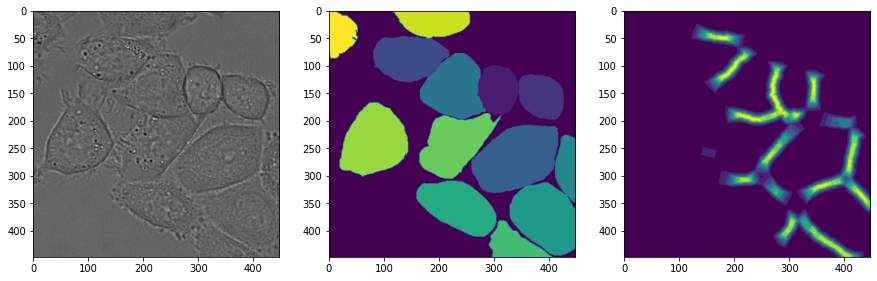

In [54]:
plt.figure(figsize=[15,5])
for x,y,z in generator: 
    x = x.squeeze(0).squeeze(0)
    y = y.squeeze(0).squeeze(0)
    z = z.squeeze(0).squeeze(0)
    plt.subplot(131)
    if imgset == 'HeLa':
        plt.imshow(x,cmap = 'gray')
    else: 
        plt.imshow(x[1])
    plt.subplot(132)
    plt.imshow(y)
    plt.subplot(133)
    plt.imshow(z)
    plt.savefig('img/sample_' + imgset + '_data.png',format='png')
    break

## 1.1 Load Harmonics

## HeLa

### Sine Functions

In [40]:
sins = [[-7.375255107879639, 5.203563690185547, 45.27313232421875],
 [-7.378573417663574, -1.9893327951431274, 20.848262786865234],
 [-7.0850653648376465, -2.456326961517334, 41.53719711303711],
 [11.45650577545166, -2.489238739013672, 31.25278091430664],
 [-1.703177571296692, -6.168859958648682, 5.964511394500732],
 [11.166621208190918, 5.2173919677734375, 38.755393981933594],
 [-0.6013728380203247, 12.734735488891602, 3.7188491821289062],
 [6.044683933258057, 12.558919906616211, 52.94304656982422],
 [5.92817497253418, -0.7977170944213867, 54.80228805541992],
 [-0.38155657052993774, 23.551265716552734, 35.34095001220703],
 [1.972337245941162, 5.383609294891357, 46.41643524169922],
 [4.012279033660889, -4.179959774017334, 35.26789093017578]]

sins = np.array(sins)
guides = guide_function(sins[:,0],sins[:,1],sins[:,2],448,448)

### Harmonic Square Waves

In [111]:
from sq_embeddings import Embedding as Embsquare
sins = [[-13.559544563293457,
  -2.203810453414917,
  21.30968475341797,
  0.9219708442687988],
 [-22.703413009643555,
  -0.37252742052078247,
  10.278214454650879,
  0.999194860458374],
 [6.941484451293945,
  -2.721510410308838,
  44.56106948852539,
  0.9472301602363586],
 [7.547652721405029, 0.9692023992538452, 39.369895935058594, 1.0],
 [-14.903787612915039,
  -1.0364874601364136,
  4.260854721069336,
  0.9993869066238403],
 [-2.7566463947296143,
  4.760617256164551,
  5.812931060791016,
  0.9590798020362854],
 [1.0290216207504272, 5.537593841552734, 15.82655143737793, 1.0],
 [-0.4228498339653015,
  -12.698473930358887,
  8.141501426696777,
  0.9982108473777771],
 [0.3880113661289215, -13.395278930664062, 4.083737373352051, 1.0],
 [6.361560344696045, -6.721468925476074, 47.4748649597168, 0.4803535044193268],
 [-0.31598857045173645,
  24.429262161254883,
  22.79106903076172,
  0.9727568030357361],
 [3.190713405609131, 5.624609470367432, 21.73563003540039, 0.9920406937599182]]

emb2 = Embsquare(sins,[448, 448])
input = torch.zeros(1,1,448,448)

guides = []
for i in range(12):
    guides.append(emb2.sins[i].generate_xy(input).detach().squeeze(0).squeeze(0).numpy())
guides = torch.tensor(np.array(guides))

## CVPPP

### Load Harmonics

In [41]:
sins = [[-24.22295570373535, 0.0, 0.4452361464500427],
 [-14.779047012329102, 0.0, 1.2561423778533936],
 [-16.399198532104492, 0.0, -0.3734317719936371],
 [18.362571716308594, 0.0, 0.7659217715263367],
 [-0.6603534817695618, 0.0, 0.24005144834518433],
 [-33.7341423034668, 0.0, -0.4350433051586151],
 [0.0, 4.286965370178223, 0.8109257817268372],
 [0.0, -19.908288955688477, 0.614355206489563],
 [0.0, 22.987812042236328, 0.28104516863822937],
 [0.0, 7.108828067779541, 0.4827950894832611],
 [0.0, 23.66850471496582, 0.21264752745628357],
 [0.0, -22.332250595092773, 1.0007625818252563]]

sins = np.array(sins)
guides = guide_function(sins[:,0],sins[:,1],sins[:,2],448,448)

## Show Harmonics 

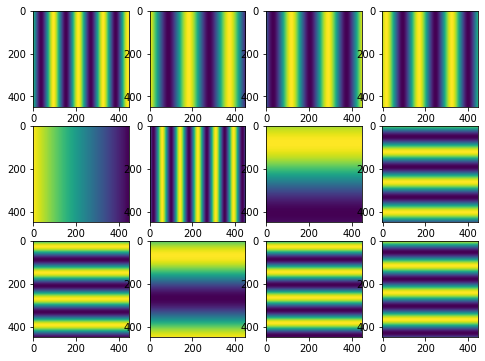

In [55]:
plt.figure(figsize=[8,6])
for i,g in enumerate(guides): 
    img = g.detach().numpy()
    plt.subplot(3,4,i+1)
    plt.imshow(img)
plt.savefig('img/sins.png',format='png')

# 2. Load Model

## HeLa

In [61]:
bpath = 'models/hela'

a) No weighted loss

In [62]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_base0_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_base0_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errors0 = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


b) Edge width of 5 (same as Harmonic Embbeddings)

In [63]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_base3_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_base3_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errors5 = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


a) Edge width of 10

In [25]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_base10_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_base10_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errors10 = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


In [88]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_basew_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_basew_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errorsw = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


## Plant Phenotyping

In [59]:
bpath = 'models/cvppp'

### Load Model

In [60]:
net = torch.nn.DataParallel(UNet(3, sins), [0]).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_ckp3.t7'):
    print('Loading')
    data = torch.load(bpath + '_ckp3.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])

net.eval()
print("Model loaded")

Loading
Model loaded


# 3. Demo Images

## HeLa 

In [109]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
 
idd = 1

torch.manual_seed(123414912)
img = HeLa_9.transform(Image.open(c.rgb[idd]).convert('L'))
torch.manual_seed(123414912)
targ = HeLa_9.transform_target(Image.open(c.labels[idd]).convert('L'))
#estimate the embeddings
emb = net(img.unsqueeze(0).to(device)).detach().cpu().numpy()

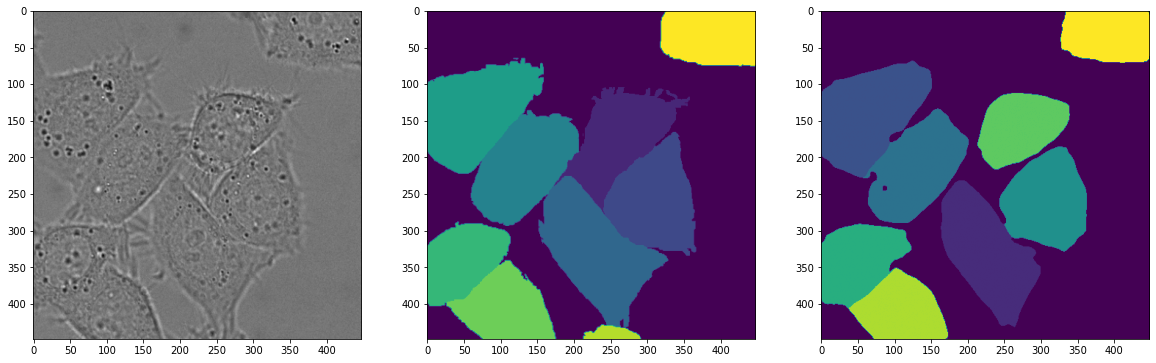

In [110]:
#cluster embeddings space
cc = cluster(emb[0],0.6,minimal_area=1000)
f,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,10))
ax[0].imshow(img[0],cmap='gray')
ax[1].imshow(targ[0])
ax[2].imshow(cc)

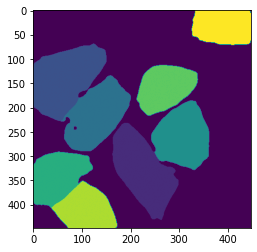

In [111]:
plt.imshow(cc)
plt.savefig('img/wx_' + str(idd) + '.png')

### Out of distribution

In [118]:
img = HeLa_9.transform(Image.open("data/ood/hestain.jpg").convert('L'))
emb = net(img.unsqueeze(0).to(device)).detach().cpu().numpy()

View Embedding

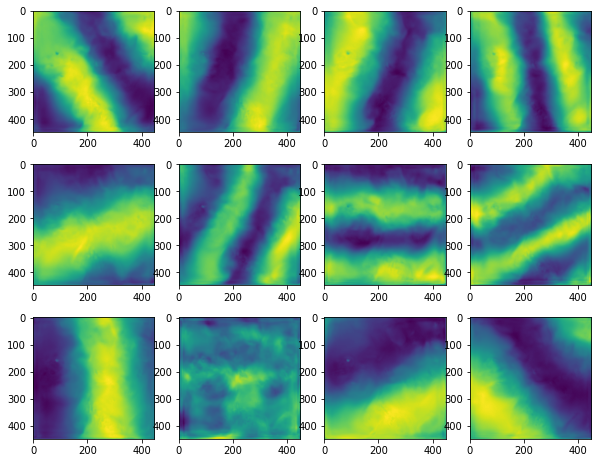

In [119]:
plt.figure(figsize=[10,8])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(emb[0][i])
plt.savefig('img/hela_ood.png',format='png')

In [120]:
cc = cluster(emb[0],0.8,minimal_area=1000)

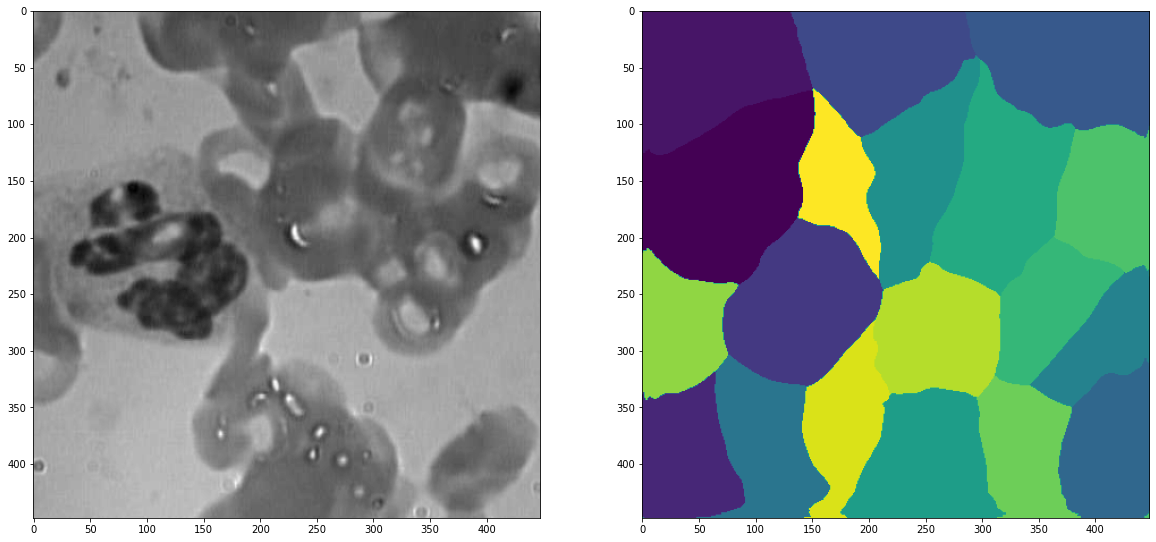

In [121]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img[0],cmap='gray')
ax[1].imshow(cc)

## CVPPP

In [144]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = plants.transform(Image.open("data/A1/plant159_rgb.png").convert('RGB'))
#estimate the embeddings
emb = net(img.unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.6,minimal_area=1000)

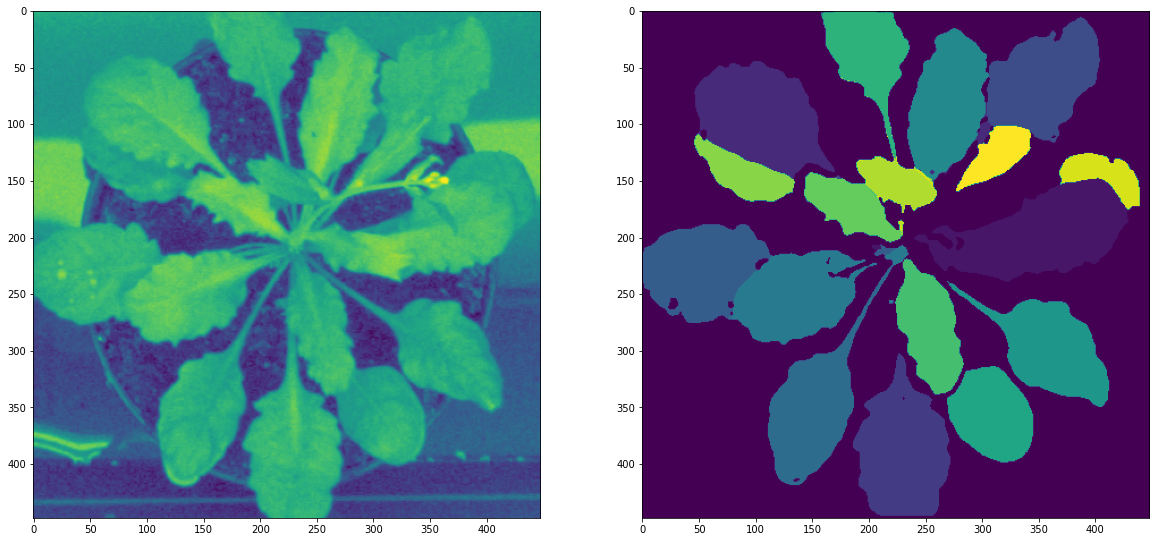

In [147]:
cc = cluster(emb[0],0.5,minimal_area=1000)
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img[1])
ax[1].imshow(cc)

## OOD

In [214]:
img = plants.transform(Image.open("data/ood/plant012_rgb.png").convert('RGB'))
#estimate the embeddings
emb = net(img.unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.5,minimal_area=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


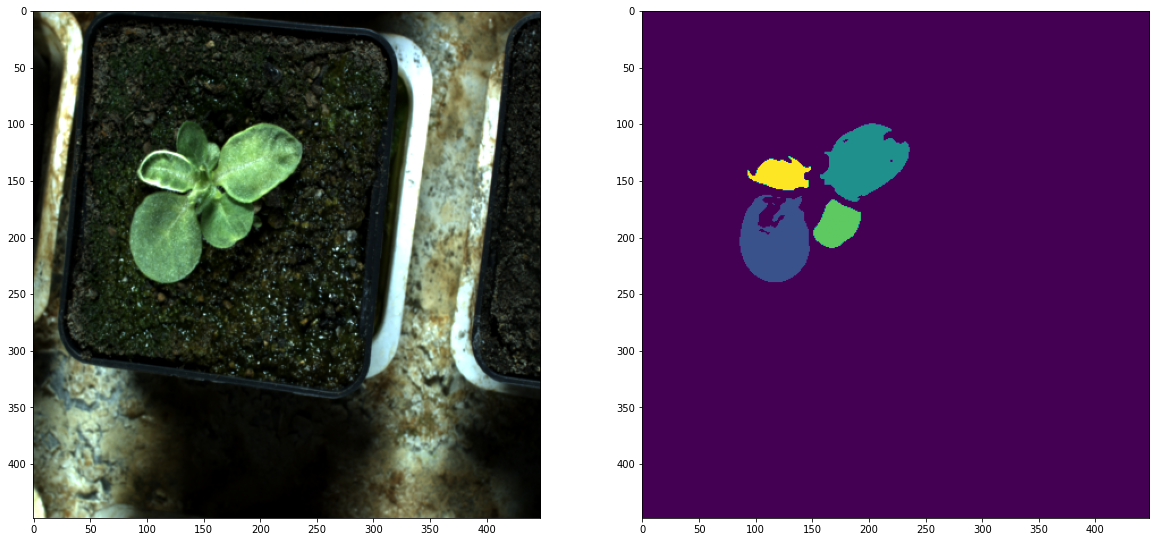

In [229]:
cc = cluster(emb[0],0.5,minimal_area=1000)
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow((img.permute(1,2,0)+2)/4)
ax[1].imshow(cc)
plt.savefig('img/ppt/oodclose.png',format='png')